## Clamp_ vs. ReLU
This method compares using clamp_ in training vs. using a ReLU activation function to enforce non-negative estimates. Do the two approaches perform comparably?

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import matplotlib.pyplot as plt
from matplotlib import gridspec
from joblib import Parallel, delayed


from AAUtoSig_init import AAUtoSig, train_AAUtoSig
from functions import simulate_counts, plotsigs, cosine_HA, split_data

# Clamp_ model
Firstly we implement the NMFAE model, which is a one-hidden layer linear autoencoder. Here the non-negativity constraint is enforced by a clamp_ argument in the training method.

In [2]:
m_pg = AAUtoSig(96, 5, non_negativity = None)

# ReLU model
Secondly we implement the same NMFAE model, but now the non-negativity constraint is enforced by introducing a ReLU activation function after encoding.

In [3]:
m_relu = AAUtoSig(96, 5, non_negativity = "ReLU")

### ReLU encoder PG decoder
See folder as to why this may be a good idea. This is also done in NSAE

In [4]:
class AAUtoSig_comb(torch.nn.Module):
    def __init__(self, feature_dim, latent_dim):
    
        super().__init__()
        

        # Building an linear encoder
        # 96 => dim
        self.enc1 = torch.nn.Linear(feature_dim, latent_dim, bias = False)
          
        # Building an linear decoder 
        # dim ==> 96
        self.dec1 = torch.nn.Linear(latent_dim, feature_dim, bias = False)
            

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = self.dec1(x)
        return x

m_comb = AAUtoSig_comb(96, 5)

### Multiplicative AE updates
Updating steps derived in the Master thesis 'Neural Networks with Nonnegativity Constraints for
Decomposing Music Recordings' by Tim Zunner. 

In [ ]:
def out_error_AAUtoSig(train_df, validation_df, model, true_sigs, loss, optimizer, epochs, non_negativity):
    train = train_df.columns
    sigs = true_sigs.index 
    #params = optuna_tune(train_df, nsigs, loss, optimizer)   

    _, out_error, _ = train_AAUtoSig(epochs, 
                                      model, 
                                      train_df, 
                                      validation_df, 
                                      loss_name= loss, 
                                      optimizer=optimizer, 
                                      batch_size = 32, 
                                      do_plot = False, 
                                      ES = False, 
                                      non_negative = non_negativity)

    signatures = model.dec1.weight.data    
    signatures = pd.DataFrame(signatures.numpy())

    cos_AE = cosine_HA(signatures.T, true_sigs.T)[0]
    cos_mean = np.mean(cos_AE.diagonal())
      
    return cos_mean, out_error

In [ ]:
def performance_analysis(npatients, nsigs, loss, epochs):
  mut_matrix, signatures, _ = simulate_counts(nsigs, npatients)
  train_data, validation_data = split_data(mut_matrix.T, 0.8)
  train_data = train_data/train_data.max().max()
  validation_data = validation_data/train_data.max().max()
  cosineAE_ReLU, out_ReLU = out_error_AAUtoSig(train_data, validation_data, m_relu, signatures, loss = loss, optimizer = optimizer_relu, epochs = epochs)
  cosineAE_PG, out_PG = out_error_AAUtoSig(train_data, validation_data, m_pg, signatures, loss = loss, optimizer_name = optimizer_pg, epochs = epochs)
  cosineAE_comb, out_comb = out_error_AAUtoSig(train_data, validation_data, m_comb, signatures, loss = loss, optimizer_name = optimizer_comb, epochs = epochs)

  return [cosineAE_ReLU, out_ReLU, cosineAE_PG, out_PG, cosineAE_comb, out_comb]

In [ ]:
n_sims = 50
n_patients = 6000
n_sigs = 7
epochs = 5000
loss_function = torch.nn.MSELoss(reduction='mean')

res = Parallel(n_jobs = 3)(delayed(performance_analysis)(n_patients, n_sigs, loss_function, epochs) for i in range(n_sims))
result = pd.DataFrame(res)
result.columns = ["ReLU_perm", "outReLU", "PG_perm", "outPG", "comb_perm", "outcomb" ]
print(result)

matplotlib.use('Agg')
fig=plt.figure()
# set height of each subplot as 8
fig.set_figheight(15)
 
# set width of each subplot as 8
fig.set_figwidth(15)

spec = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[2.3, 1], wspace=0.2,
                         hspace=0.2, height_ratios=[2.3, 1])


ax1 = fig.add_subplot(spec[0])
plt.scatter(y = result['ReLU_perm'], x = result['outReLU'], c = 'blue', label = 'ReLU')
plt.scatter(y = result['PG_perm'], x = result['outPG'], c = 'red', label = 'PG')
plt.scatter(y = result['comb_perm'], x = result['outcomb'], c = 'green', label = 'ReLU + PG')
#plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.legend()
ax2 = fig.add_subplot(spec[1])
plt.boxplot(result[['NMF_perm', 'AE_perm']] ,labels = ["NMF", "AE"])
#plt.ylabel('mean diagonal cosine')
ax3 = fig.add_subplot(spec[2])
plt.boxplot(result[['outAE', 'outNMF']], labels = ["AE", "NMF"], vert=False)
plt.xlabel('Out of sample error')

ax1.get_shared_x_axes().join(ax1, ax3)
ax1.get_shared_y_axes().join(ax1, ax2)

plt.show()


# Evaluate
Now we evaluate the results on simulated data.

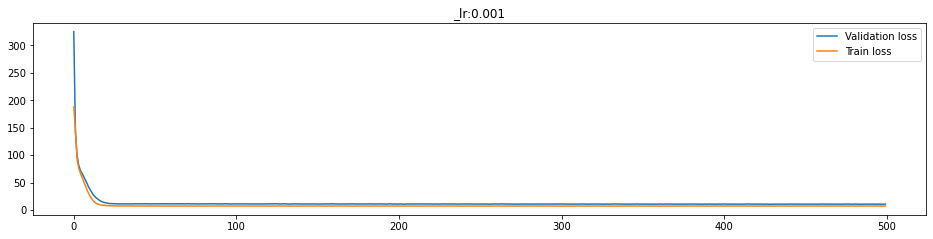

<Figure size 432x288 with 0 Axes>

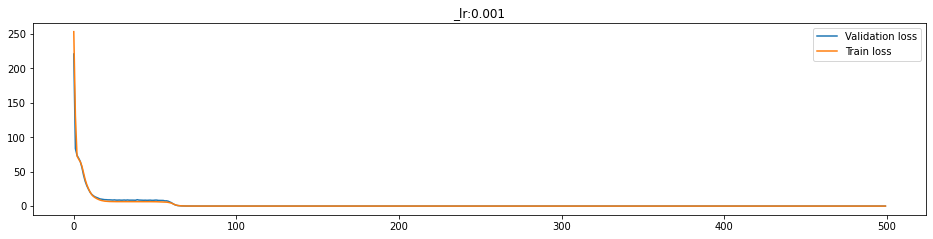

<Figure size 432x288 with 0 Axes>

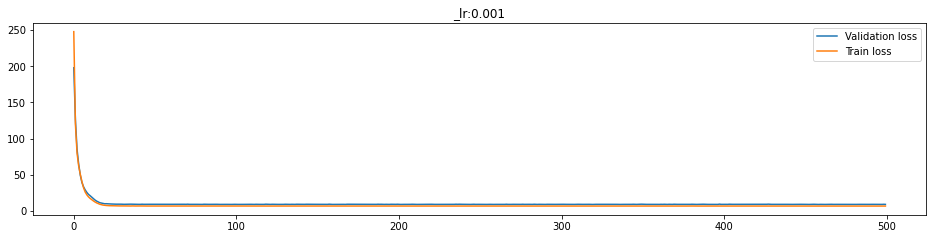

<Figure size 432x288 with 0 Axes>

In [5]:
n_sigs = 5

V,S,E = simulate_counts(5, 2000)
train_data, validation_data = split_data(V.T, 0.8)
trinucleotide = V.index
mutation = [t[2:5] for t in trinucleotide]


# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer_pg = torch.optim.Adam(m_pg.parameters(),
                            lr = 1e-3)
optimizer_relu = torch.optim.Adam(m_relu.parameters(),
                            lr = 1e-3)
optimizer_comb = torch.optim.Adam(m_comb.parameters(),
                            lr = 1e-3)




In [ ]:

train_AAUtoSig(epochs = 500, 
                model = m_pg, 
                x_train = train_data,
                x_test = validation_data, 
                criterion = loss_function, 
                optimizer = optimizer_clamp,
                batch_size = 16,
                non_negative = "all")


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_clamp = m_clamp.dec1.weight.data    
sigs_clamp = pd.DataFrame(sigs_clamp.numpy()) 

# Using an Adam Optimizer with lr = 1e-3
train_AAUtoSig(epochs = 500, 
                model = m_relu, 
                x_train = train_data,
                x_test = validation_data, 
                criterion = loss_function, 
                optimizer = optimizer_relu,
                batch_size = 16,
                non_negative = None)


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_relu = F.relu(m_relu.dec1.weight.data)    
sigs_relu = pd.DataFrame(sigs_relu.numpy()) 


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_clamp = m_clamp.dec1.weight.data    
sigs_clamp = pd.DataFrame(sigs_clamp.numpy()) 

train_AAUtoSig(epochs = 500, 
                model = m_comb, 
                x_train = train_data,
                x_test = validation_data, 
                criterion = loss_function, 
                optimizer = optimizer_comb,
                batch_size = 16,
                non_negative = "bases")


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_comb = F.relu(m_comb.dec1.weight.data)    
sigs_comb = pd.DataFrame(sigs_comb.numpy()) 


In [6]:
cosine_clamp, perm_clamp = cosine_HA(sigs_clamp.T, S.T)
cosine_relu, perm_relu = cosine_HA(sigs_relu.T, S.T)
cosine_comb, perm_comb = cosine_HA(sigs_comb.T, S.T)

print("cosine values for clamped:")
print(cosine_clamp.diagonal())
print(np.mean(cosine_clamp.diagonal()))

print("cosine values for relu:")
print(cosine_relu.diagonal())
print(np.mean(cosine_relu.diagonal()))

print("cosine values for comb:")
print(cosine_comb.diagonal())
print(np.mean(cosine_comb.diagonal()))



cosine values for clamped:
[0.94438072 0.23446272 0.99949303 0.9818027  0.9991232 ]
0.8318524728652127
cosine values for relu:
[0.79597592 0.79879898 0.79285681 0.99596554 0.33706507]
0.7441324627227098
cosine values for comb:
[0.977536   0.27288895 0.99960132 0.9794213  0.99950596]
0.8457907052019171


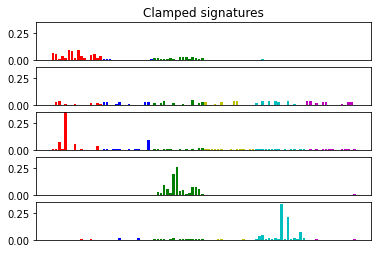

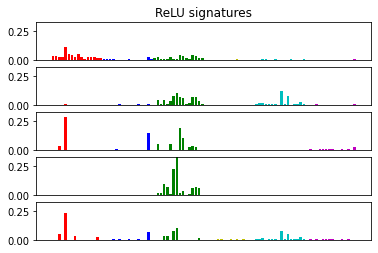

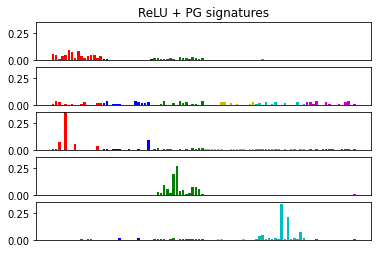

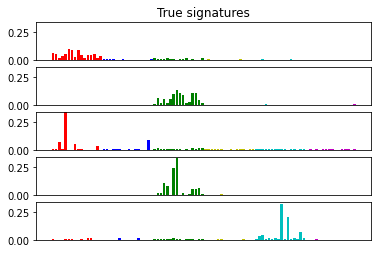

In [7]:
plotsigs(trinucleotide, sigs_clamp[perm_clamp].to_numpy(), 5, "Clamped signatures")  
plotsigs(trinucleotide, sigs_relu[perm_relu].to_numpy(), 5, "ReLU signatures")  
plotsigs(trinucleotide, sigs_comb[perm_comb].to_numpy(), 5, "ReLU + PG signatures")  
plotsigs(trinucleotide, S.to_numpy(), 5, "True signatures")  